In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

keras = tf.keras

In [2]:
df=pd.read_csv("GOOGL.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7
0,19-08-2004,50.050049,52.082081,48.028027,50.220219,50.220219,44659096.0,NaN
1,20-08-2004,50.555557,54.594597,50.300301,54.209209,54.209209,22834343.0,NaN
2,23-08-2004,55.430431,56.796799,54.579578,54.754753,54.754753,18256126.0,NaN
3,24-08-2004,55.675674,55.855858,51.836838,52.487488,52.487488,15247337.0,NaN
4,25-08-2004,52.532532,54.054054,51.991993,53.053055,53.053055,9188602.0,NaN


In [3]:
closing_price=df["Close"]
dates=df["Date"]
df['Date'] = pd.to_datetime(df['Date'])
# df['DateSerial'] = df['Date'].apply(lambda x: x.toordinal())
# dates=df["DateSerial"]-df["DateSerial"][0]

<ipython-input-3-6ba21afcb2b0>:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


In [8]:
series = df['Close']

# Create train data set
train_split_date = '30-12-2015'
train_split_index = np.where(df.Date == train_split_date)[0][0]
x_train = df.loc[df['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '01-02-2019'
test_split_index = np.where(df.Date == test_split_date)[0][0]
x_test = df.loc[df['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = df.loc[(df['Date'] < test_split_date) & (df['Date'] > train_split_date)]['Close']

2861 2862 3616 3617 3998


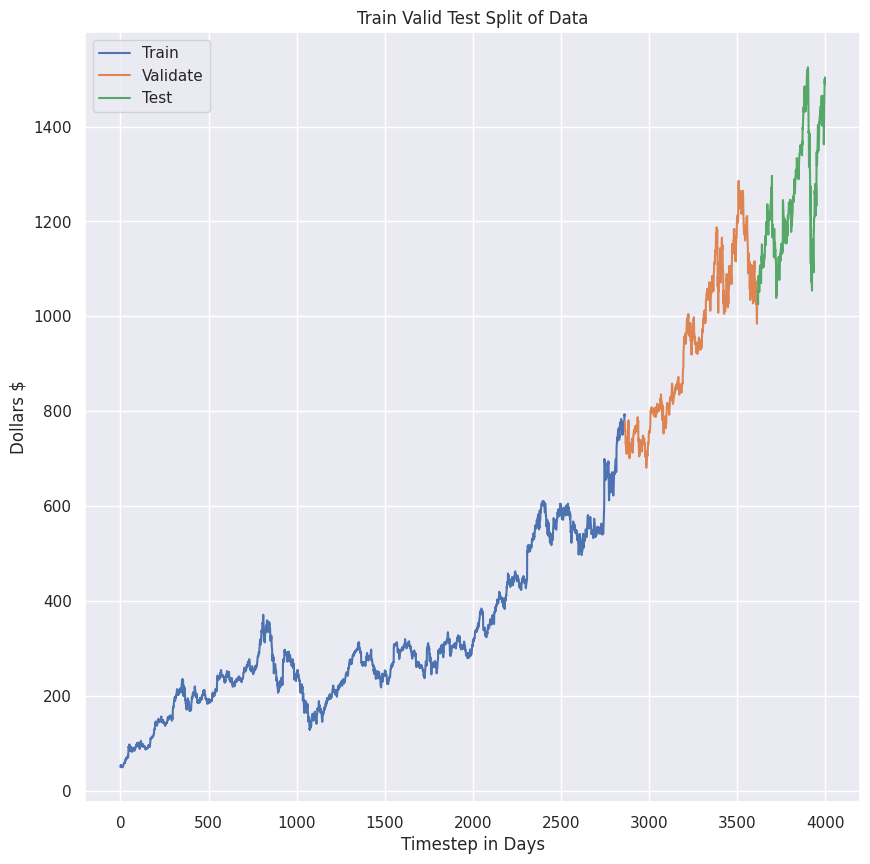

In [9]:
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [10]:
# Lets create a dictionary to store all of our model training scores to view later
model_mae_scores = {}

Text(0.5, 1.0, 'Price History of TSLA Jan-1993 to Dec-2020')

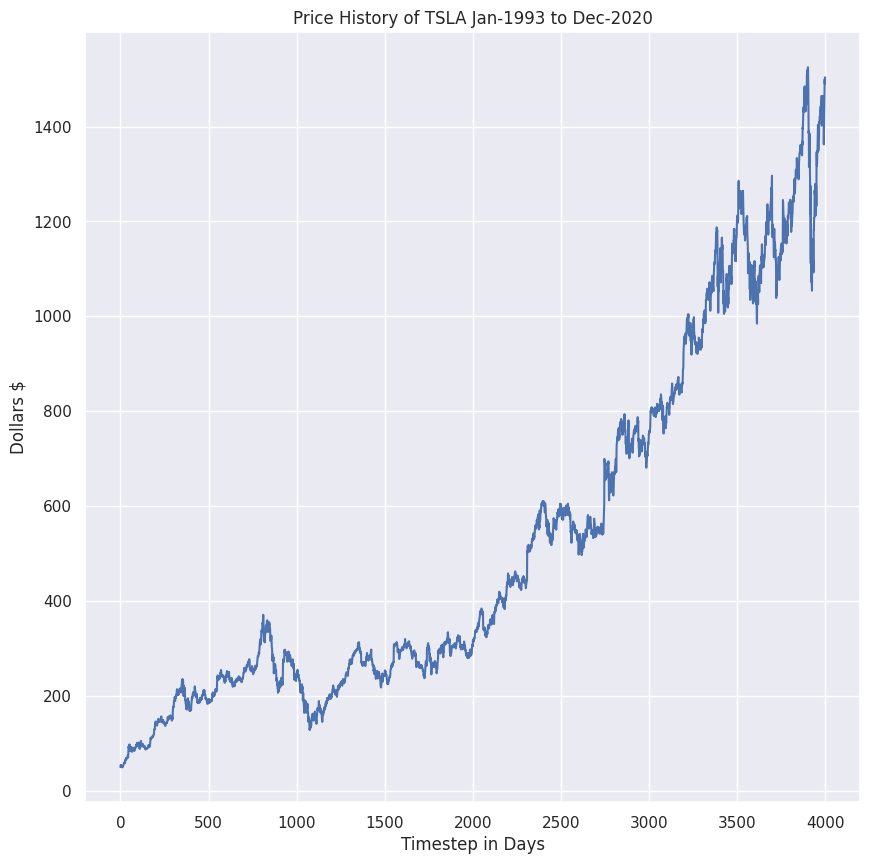

In [59]:
plt.plot(df['Close'])
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('Price History of TSLA Jan-1993 to Dec-2020')

Checking if stationary for applying ARIMA models

In [23]:
# Testing for stationarity
from statsmodels.tsa.stattools import adfuller

test_result=adfuller(closing_price.dropna())

In [24]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [25]:
adfuller_test(closing_price.dropna())

ADF Test Statistic : 0.8842445628317324
p-value : 0.9928812301094921
#Lags Used : 30
Number of Observations Used : 3968
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Differencing to make the Closing Price Stationary

In [26]:
df["Difference_1"]=closing_price-closing_price.shift(1)

In [27]:
adfuller_test(df["Difference_1"].dropna())

ADF Test Statistic : -11.377006234088173
p-value : 8.695882730295604e-21
#Lags Used : 31
Number of Observations Used : 3966
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Hence the First difference can be treated as stationary

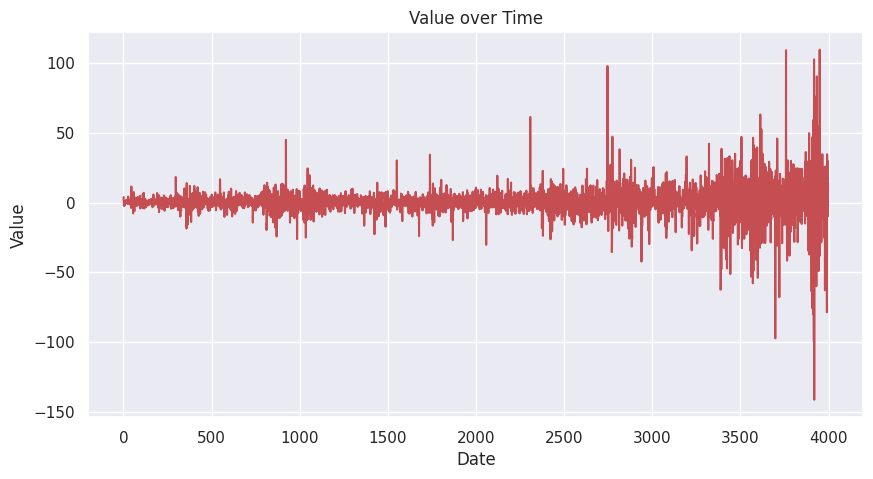

In [30]:
#Plotting the first difference of Closing Price
plt.figure(figsize=(10,5))
plt.plot(df["Difference_1"].dropna(),color="r")
plt.title('Value over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


Defining AR model

In [31]:
from statsmodels.tsa.arima.model import ARIMA

# fit model
nvidia_arima = ARIMA(x_train, order=(1,1,1))
nvidia_arima_fit = nvidia_arima.fit()
print(nvidia_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2862
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -9180.973
Date:                Thu, 23 May 2024   AIC                          18367.946
Time:                        07:28:27   BIC                          18385.823
Sample:                             0   HQIC                         18374.392
                               - 2862                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1074      0.536     -0.200      0.841      -1.158       0.943
ma.L1          0.1357      0.536      0.253      0.800      -0.915       1.186
sigma2        35.8782      0.252    142.380      0.0

NormaltestResult(statistic=1789.6666633960065, pvalue=0.0)
This distribution is not a normal distribution


<ipython-input-32-341f05d39f04>:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats


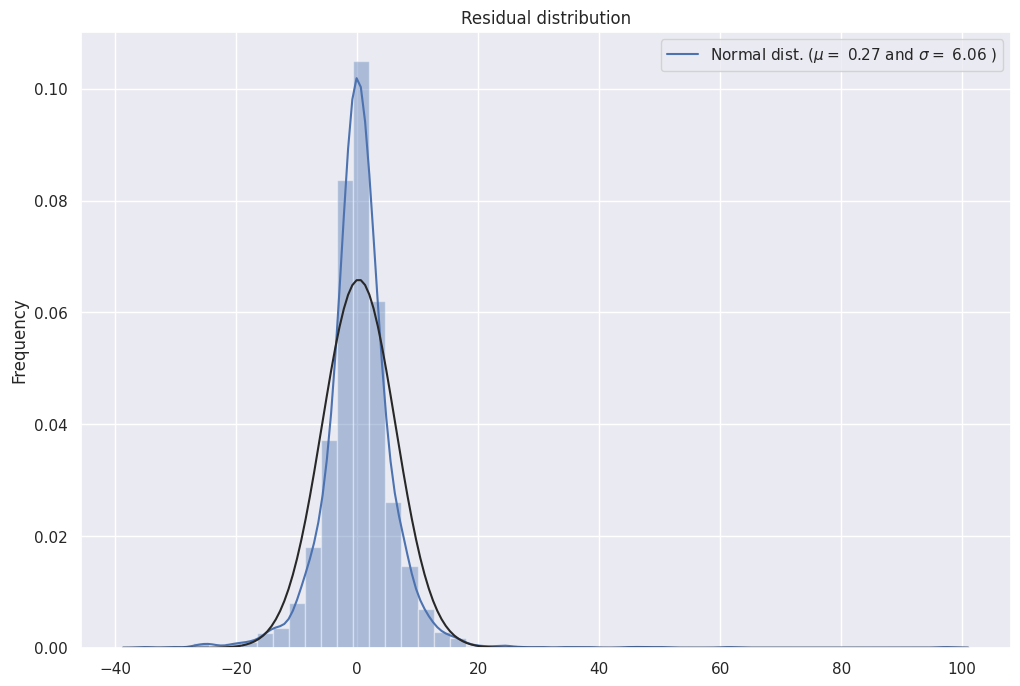

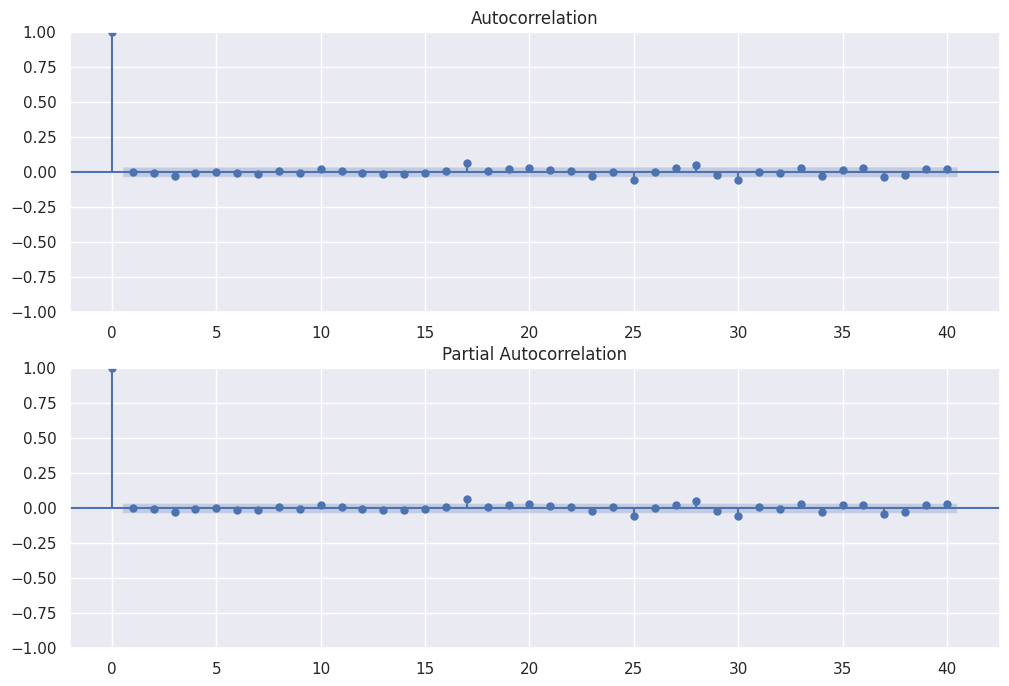

In [32]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = nvidia_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

In [33]:
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

# loop through every data point
for time_point in list(x_test.index[-100:]):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [34]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = keras.metrics.mean_absolute_error(x_test[-100:], model_predictions).numpy()
# Save to our dictionary of model mae scores
model_mae_scores['ARIMA'] = arima_mae
model_mae_scores

{'ARIMA': 35.85500909781393}

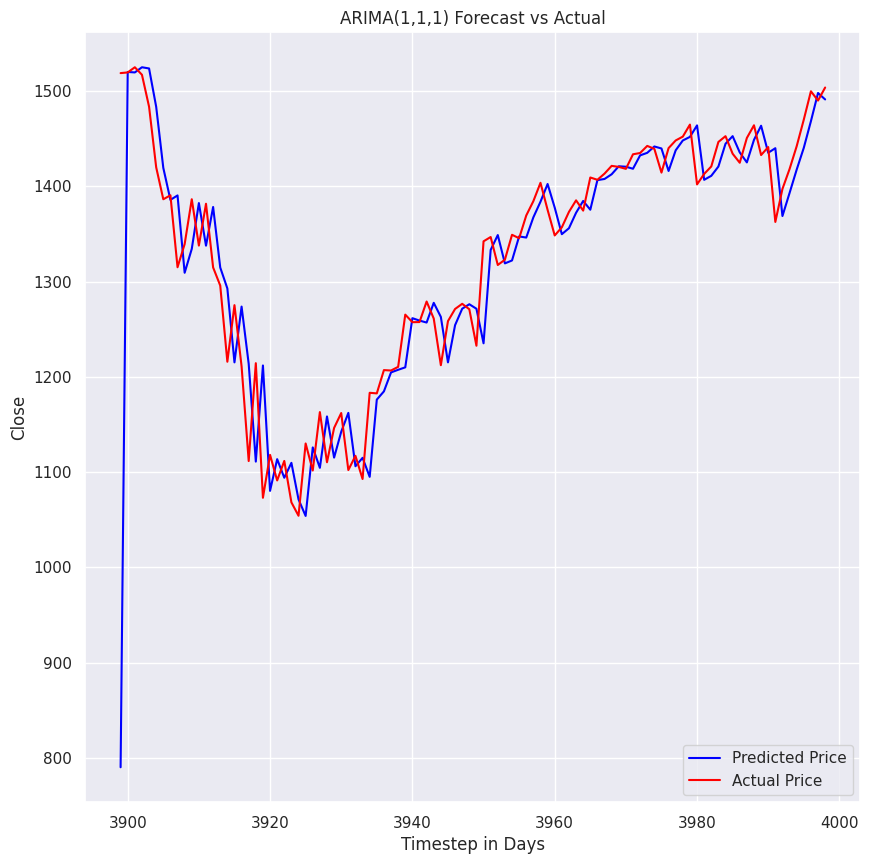

<Figure size 1000x600 with 0 Axes>

In [35]:

plt.plot(x_test.index[-100:], model_predictions, color='blue',label='Predicted Price')
plt.plot(x_test.index[-100:], x_test[-100:], color='red', label='Actual Price')
plt.ylabel('Close')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(1,1,1) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

We can observe that we are able to get a fair capture of the trend using ARIMA(1,1,1) but Naive estimator outperforms the ARIMA in our case

In [36]:
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_train)

# loop through every data point
for time_point in list(x_train.index[-250:]):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_train[time_point]
    history.append(true_test_value)


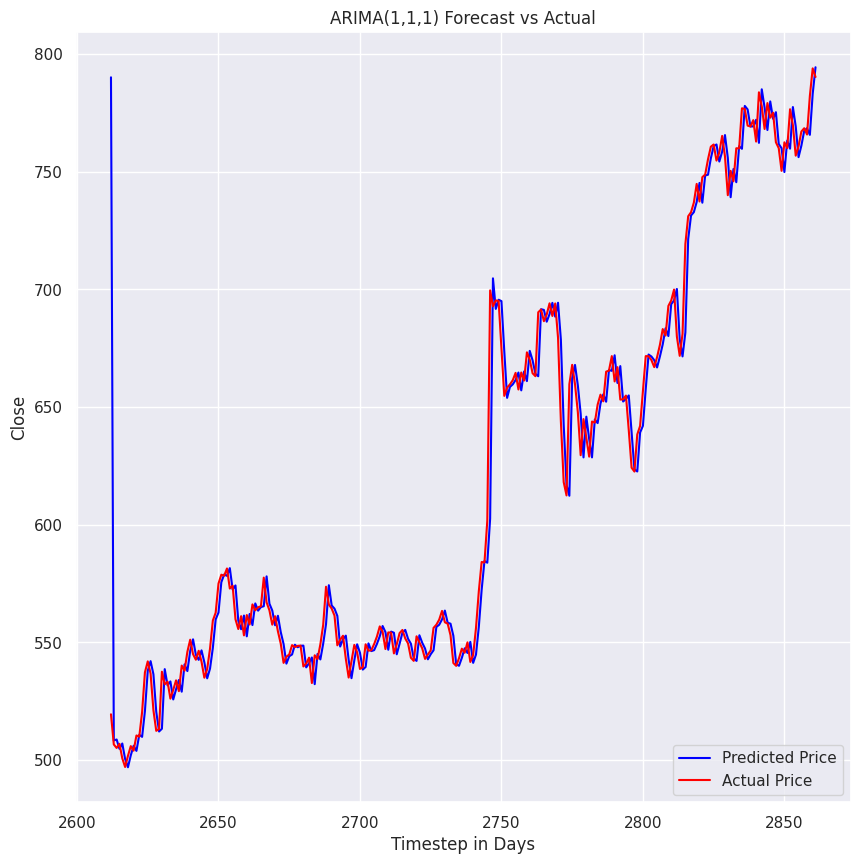

<Figure size 1000x600 with 0 Axes>

In [37]:

plt.plot(x_train.index[-250:], model_predictions, color='blue',label='Predicted Price')
plt.plot(x_train.index[-250:], x_train[-250:], color='red', label='Actual Price')
plt.ylabel('Close')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(1,1,1) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

**LSTM**

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df["Close"]).reshape(-1,1))

In [39]:
print(df1)

[[0.00011199]
 [0.00281673]
 [0.00318664]
 ...
 [       nan]
 [       nan]
 [       nan]]


In [40]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [41]:
training_size,test_size

(2880, 1551)

In [42]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [43]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [44]:
print(X_train.shape), print(y_train.shape)

(2779, 100)
(2779,)


(None, None)

In [45]:
print(X_test.shape), print(ytest.shape)

(1450, 100)
(1450,)


(None, None)

In [46]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [47]:
### Create the Stacked LSTM model
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [48]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
44/44 [==============================] - 16s 239ms/step - loss: 0.0047 - val_loss: nan
Epoch 2/100
44/44 [==============================] - 9s 206ms/step - loss: 1.9822e-04 - val_loss: nan
Epoch 3/100
44/44 [==============================] - 8s 175ms/step - loss: 1.5207e-04 - val_loss: nan
Epoch 4/100
44/44 [==============================] - 9s 209ms/step - loss: 1.3885e-04 - val_loss: nan
Epoch 5/100
44/44 [==============================] - 9s 215ms/step - loss: 1.3605e-04 - val_loss: nan
Epoch 6/100
44/44 [==============================] - 8s 174ms/step - loss: 1.3392e-04 - val_loss: nan
Epoch 7/100
44/44 [==============================] - 9s 210ms/step - loss: 1.3032e-04 - val_loss: nan
Epoch 8/100
44/44 [==============================] - 8s 185ms/step - loss: 1.2968e-04 - val_loss: nan
Epoch 9/100
44/44 [==============================] - 8s 191ms/step - loss: 1.2333e-04 - val_loss: nan
Epoch 10/100
44/44 [==============================] - 9s 211ms/step - loss: 1.2150e-0

In [51]:
import tensorflow as tf

In [52]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

46/46 [==============================] - 2s 35ms/step


In [53]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [62]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_train,train_predict)

325.6153406754472

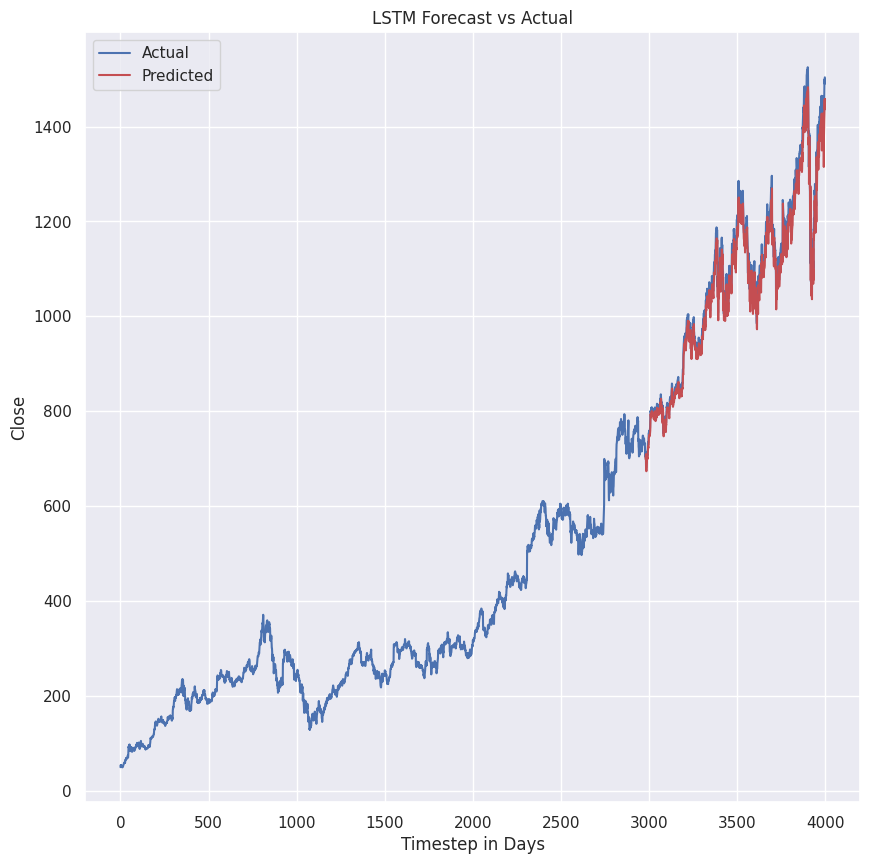

In [58]:
look_back=100
# trainPredictPlot = numpy.empty_like(df1)
# trainPredictPlot[:, :] = np.nan
# trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
# plt.plot(scaler.inverse_transform(df1))
# plt.plot(trainPredictPlot)
plt.plot(scaler.inverse_transform(df1),color="b",label="Actual")
plt.plot(testPredictPlot,color="r",label="Predicted")
plt.ylabel('Close')
plt.xlabel('Timestep in Days')
plt.title('LSTM Forecast vs Actual')
plt.legend()
plt.show()